In [660]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.metrics import r2_score

In [667]:
path = "/home/raim/data/mistrans/processedData/saap_context.tsv"
df = pd.read_csv(path, delimiter='\t')
distinct_df = pd.DataFrame(df)
#distinct_df = original_df.drop_duplicates(subset='transition_group_id')

TYPE = 'peptide' #'codon' #
if (TYPE=='peptide'):
    ABC = "ACDEFGHIKLMNPQRSTVWYXUZ"   # NOTE: U: selenocysteine, X: unknown, Z:gaps
else:
    ABC = "AGCT"

max_sequence_length = len(distinct_df[TYPE][1])    # set the maximum sequence length 
num_amino_acids = len(ABC)            # number of possible amino acids


#print(distinct_df['peptide'])
print(len(ABC))
print(len(distinct_df[TYPE][1]))

23
1


In [668]:
# create a dictionary to map amino acids to their indices
amino_acid_to_index = {aa: i for i, aa in enumerate(ABC)}

def one_hot_encode_sequence(sequence):
    one_hot_sequence = np.zeros((max_sequence_length, num_amino_acids), dtype=np.float32)
    for i, aa in enumerate(sequence[:max_sequence_length]):
        aa_index = amino_acid_to_index.get(aa.upper(), None)
        if aa_index is not None:
            one_hot_sequence[i, aa_index] = 1.0
    return one_hot_sequence
    
X_peptide = [one_hot_encode_sequence(seq) for seq in distinct_df[TYPE]]

#print(X_peptide[1])
print(len(X_peptide[1]))
#print(distinct_df['median'].values)

1


In [669]:


# concatenate peptide sequences 
#X = [np.concatenate((X_peptide[i], np.tile(X_charge[i], (max_sequence_length, 1))), axis=1) for i in range(len(X_peptide))]
X = X_peptide
Y = distinct_df['median'].values
#weights = 1/distinct_df['cv'].values

# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test, weights_train, weights_test = train_test_split(X, Y, weights, test_size=0.1, random_state=42)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

In [670]:
def weighted_mean_absolute_error(y_true, y_pred, weights):
    """
    Weighted Mean Absolute Error custom loss function.

    :param y_true: True labels
    :param y_pred: Predicted labels
    :param weights: Weights for each sample (based on Ms1ProfileCorr)
    :return: Weighted MAE
    """
    # Calculate the absolute error
    error = tf.abs(y_pred - y_true)
    transformed_weights = weights+0.1

    # Apply weights
    weighted_error = error * transformed_weights
    
    # Return the mean of the weighted error
    return tf.reduce_mean(weighted_error)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(max_sequence_length, num_amino_acids)),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(220, activation='relu'),
    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(160, activation='relu'),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(100, activation='relu'),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(50, activation='relu'),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(10, activation='relu'),
#    tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(1, activation='linear') 
])

# compile
#model.compile(optimizer='adam', loss=lambda y_true, y_pred: weighted_mean_absolute_error(y_true, y_pred, weights))
model.compile(optimizer='adam', loss='mse')  # Customize loss function for your task

# train
model.fit(np.array(X_train), Y_train, epochs=10, batch_size=32, validation_split=0.1)

# predict
Y_pred = model.predict(np.array(X_test))
Y_pred = Y_pred.flatten()

Epoch 1/10


/home/raim/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8894 - val_loss: 1.2710
Epoch 2/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3924 - val_loss: 1.3002
Epoch 3/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3999 - val_loss: 1.3091
Epoch 4/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3553 - val_loss: 1.2743
Epoch 5/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4294 - val_loss: 1.3013
Epoch 6/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4026 - val_loss: 1.2988
Epoch 7/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3483 - val_loss: 1.2792
Epoch 8/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3695 - val_loss: 1.2849
Epoch 9/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3754 - val_loss: 1.2868
Epoch 10/10
146/146 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4245 - val_loss: 1.2732
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [671]:
# evaluate the model
mse = np.mean((Y_pred - Y_test) ** 2)
print("Mean Squared Error:", mse)

mae = np.mean(np.abs(Y_pred - Y_test))
print("Mean Absolute Error:", mae)

med_ae = np.median(np.abs(Y_pred - Y_test))
print("Median Absolute Error:", med_ae)

coefficient_of_dermination = r2_score(Y_test, Y_pred)
print("R-squared: ",coefficient_of_dermination)

pearsonr = np.corrcoef(Y_test, Y_pred)
print("r: ",pearsonr[0,1])

file_name="/home/raim/data/mistrans/processedData/saap_context_prediction.tsv"
outdf = pd.DataFrame({'RAAS.real':Y_test, 'RAAS.predicted':Y_pred})
outdf.to_csv(file_name, sep='\t')

Mean Squared Error: 1.4486692459107566
Mean Absolute Error: 0.9461540173460437
Median Absolute Error: 0.7933527544619325
R-squared:  0.08721499681800926
r:  0.3029701248075463


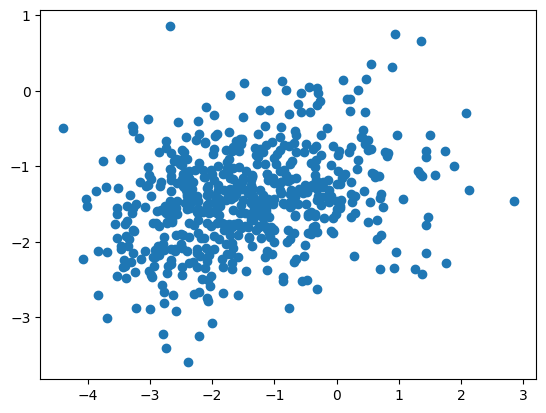

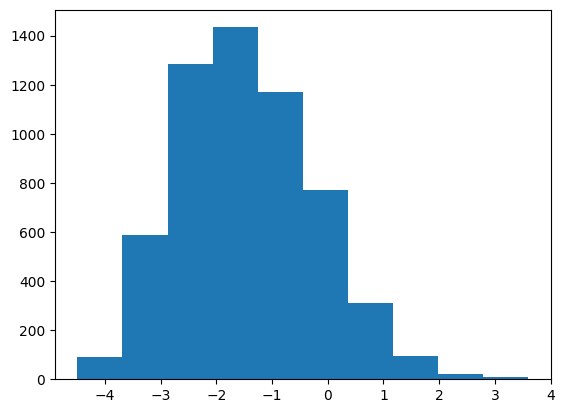

In [666]:
from matplotlib import pyplot as plt 
# Function to plot 
plt.scatter(Y_test, Y_pred) 
 
# function to show the plot 
plt.show()

plt.hist(distinct_df['median'].values)
plt.show()